
# MEA module re-write

In [1]:
import mdbread
#import dill
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from functools import partial

%matplotlib inline

from ipywidgets import FloatProgress
from IPython.display import display

In [30]:
def read_basenames(path):
    return [line.lower().strip().split(' ')[0] 
        for line in open(path, 'r') if not line.startswith('#')]

def discount(x, dr, col, ref_year):
    return x[col] / pow(1 + dr, x['year'] - ref_year)  

In [3]:
dat_path = '../dat'
mea_db_path = dat_path + '/mea.db'
cat_db_path = dat_path + '/cat_out/20181024_results'
cat_db_name = 'default_base_future_aggregated_results.db'

basenames = [int(x[-2:]) for x in read_basenames(dat_path+'/basenames.txt')]

In [39]:
min_time, max_time = 2020, 2069
apy1, apy2 = 2020, 2069
filter_time = True
ref_year = 2020
fms_emit_factor = 1. # 0.000001

In [5]:
pcfms_tn = 'pricecost_fms'
pchwp_tn = 'pricecost_hwp'
pcdis_tn = 'pricecost_dis'

Equivalent of UpdateAssumptionsInMEA()

In [6]:
# discount rates (extracted from db.tblDiscountRates)
params_dr = {'dr_soci_econ':0.03,
             'dr_soci_emit':0.01,
             'dr_priv_econ':0.07,
             'dr_priv_emit':0.00}

# displacement factors (extracted from tblDisplacementFactors)
params_df = {'sawnwood_m3':{'concrete':3.46, 'plastic':1.}, # was 0.59 for steel in PICS phase 1
             'panels_m3':{'concrete':3.89, 'plastic':1.}}    # was 0.85 for steel in PICS phase 1

In [7]:
scen_col = 'scenario'
unit_col = 'tsa_num'
time_col = 'year'

There are two different scenario aggregation levels (hierarchical).

In [8]:
scenario_names1_ref = 'CBM_BASE'
scenario_names1 = ['CBM_BASE', 'CBM_A', 'CBM_B', 'CBM_C', 'CBM_D', 'CBM_OG']
# scenario_names1 = ['CBM_BASE':('_HWP_Base', '_HWP_LLP'),
#                    'CBM_A':('_HWP_Base', '_HWP_LLP'),
#                    'CBM_B':('_HWP_Base', '_HWP_LLP'),
#                    'CBM_C':('_HWP_Base', '_HWP_LLP'),
#                    'CBM_D':('_HWP_Base', '_HWP_LLP'),
#                    'CBM_OG':('_HWP_Base', '_HWP_LLP')}
scenario_names2_ref = 'CBM_Base_HWP_Base'
scenario_names2 = {'CBM_Base_HWP_Base':('CBM_BASE', {'fms':1, 'hwp':1, 'nrg':1, 'ds1':1, 'ds2':1}),
                   'CBM_Base_HWP_LLP':('CBM_BASE', {'fms':1, 'hwp':1, 'nrg':1, 'ds1':1, 'ds2':1}),
                   'CBM_A_HWP_Base':('CBM_A', {'fms':1, 'hwp':1, 'nrg':1, 'ds1':1, 'ds2':1}),
                   'CBM_A_HWP_LLP':('CBM_A', {'fms':1, 'hwp':1, 'nrg':1, 'ds1':1, 'ds2':1}),
                   'CBM_B_HWP_Base':('CBM_B', {'fms':1, 'hwp':1, 'nrg':1, 'ds1':1, 'ds2':1}),
                   'CBM_B_HWP_LLP':('CBM_B', {'fms':1, 'hwp':1, 'nrg':1, 'ds1':1, 'ds2':1}),
                   'CBM_C_HWP_Base':('CBM_C', {'fms':1, 'hwp':1, 'nrg':1, 'ds1':1, 'ds2':1}),
                   'CBM_C_HWP_LLP':('CBM_C', {'fms':1, 'hwp':1, 'nrg':1, 'ds1':1, 'ds2':1}),
                   'CBM_D_HWP_Base':('CBM_D', {'fms':1, 'hwp':1, 'nrg':1, 'ds1':1, 'ds2':1}),
                   'CBM_D_HWP_LLP':('CBM_D', {'fms':1, 'hwp':1, 'nrg':1, 'ds1':1, 'ds2':1}),
                   'CBM_OG_HWP_Base':('CBM_OG', {'fms':1, 'hwp':1, 'nrg':1, 'ds1':1, 'ds2':1}),
                   'CBM_OG_HWP_LLP':('CBM_OG', {'fms':1, 'hwp':1, 'nrg':1, 'ds1':1, 'ds2':1})}

Results where compiled using different assumption sets. Analysis must be repeated for each assumption set.

In [9]:
# load model parameters from database
cnn1 = sqlite3.connect(mea_db_path)
#c1 = cnn1.cursor()

In [10]:
assid_col = 'assumption_id'
df_pcfms = pd.read_sql_query('select * from %s' % pcfms_tn, cnn1)
df_pcfms[unit_col] = df_pcfms[unit_col].astype(int)
df_pcfms = df_pcfms.set_index([assid_col, unit_col]) 
df_pcfms.head()

SWLogPrice  HWLogPrice  SalvageLogPrice  ResiduePrice  \
assumption_id tsa_num                                                          
3             1              53.0        43.0             43.0           0.0   
              2              53.0        43.0             43.0           0.0   
              3              53.0        43.0             43.0           0.0   
              4              53.0        43.0             43.0           0.0   
              5              53.0        43.0             43.0           0.0   

                       SWLogCost  HWLogCost  SalvageLogCost  ResidueCost  
assumption_id tsa_num                                                     
3             1        48.369999  38.369999       38.369999          0.0  
              2        48.369999  38.369999       38.369999          0.0  
              3        48.369999  38.369999       38.369999          0.0  
              4        48.369999  38.369999       38.369999          0.0  
              5        48.369999  38.369999       38.369999          0.0

In [11]:
assid_col = 'assumption_id'
df_pchwp = pd.read_sql_query('select * from %s' % pchwp_tn, cnn1)
df_pchwp[unit_col] = df_pchwp[unit_col].astype(int)
df_pchwp = df_pchwp.set_index([assid_col, unit_col])
df_pchwp.head()

SawnwoodPrice  PanelPrice  OtherIRPrice  PulpPrice  \
assumption_id tsa_num                                                       
1             1                130.0       273.0         130.0      831.0   
              2                130.0       273.0         130.0      831.0   
              3                130.0       273.0         130.0      831.0   
              4                130.0       273.0         130.0      831.0   
              5                130.0       273.0         130.0      831.0   

                       BioenergyFromProductEOLPrice  \
assumption_id tsa_num                                 
1             1                           64.592514   
              2                           64.592514   
              3                           64.592514   
              4                           64.592514   
              5                           64.592514   

                       BioenergyFromHarvestPrice  \
assumption_id tsa_num                              
1             1                        64.592514   
              2                        64.592514   
              3                        64.592514   
              4                        64.592514   
              5                        64.592514   

                       BioenergyFromHarvestResiduePrice  \
assumption_id tsa_num                                     
1             1                               64.592514   
              2                               64.592514   
              3                               64.592514   
              4                               64.592514   
              5                               64.592514   

                       BioenergyFromMillResiduePrice  SawnwoodCost  PanelCost  \
assumption_id tsa_num                                                           
1             1                            64.592514         110.0      265.0   
              2                            64.592514         110.0      265.0   
              3                            64.592514         110.0      265.0   
              4                            64.592514         110.0      265.0   
              5                            64.592514         110.0      265.0   

                       OtherIRCost  PulpCost  BioenergyFromProductEOLCost  \
assumption_id tsa_num                                                       
1             1              110.0     658.0                          0.0   
              2              110.0     658.0                          0.0   
              3              110.0     658.0                          0.0   
              4              110.0     658.0                          0.0   
              5              110.0     658.0                          0.0   

                       BioenergyFromHarvestCost  \
assumption_id tsa_num                             
1             1                       95.397598   
              2                      111.523636   
              3                       54.663036   
              4                      104.772491   
              5                       54.663036   

                       BioenergyFromHarvestResidueCost  \
assumption_id tsa_num                                    
1             1                              95.397598   
              2                             111.523636   
              3                              54.663036   
              4                             104.772491   
              5                              54.663036   

                       BioenergyFromMillResidueCost  
assumption_id tsa_num                                
1             1                                 0.0  
              2                                 0.0  
              3                                 0.0  
              4                                 0.0  
              5                                 0.0

In [12]:
assid_col = 'assumption_id'
df_pcdis = pd.read_sql_query('select * from %s' % pcdis_tn, cnn1)
df_pcdis[unit_col] = df_pcdis[unit_col].astype(int)
df_pcdis = df_pcdis.set_index([assid_col, unit_col])

# HACK #######
# Waiting for plastic price and cost data (from ZX).
# For now, we can simply rename SteelPrice->PlasticPrice and SteelCost->PlasticCost.
df_pcdis.rename(columns={'SteelPrice':'PlasticPrice', 'SteelCost':'PlasticCost'}, inplace=True)
##############

df_pcdis.head()

ConcretePrice  PlasticPrice  EnergyPrice  ConcreteCost  \
assumption_id tsa_num                                                           
2             1                 65.0         834.0    74.238686          64.0   
              2                 65.0         834.0   115.760292          64.0   
              3                 65.0         834.0   120.000000          64.0   
              4                 65.0         834.0   106.263184          64.0   
              5                 65.0         834.0    38.180752          64.0   

                       PlasticCost  EnergyCost  
assumption_id tsa_num                           
2             1              791.0  121.602562  
              2              791.0  212.397934  
              3              791.0   63.365952  
              4              791.0  180.710068  
              5              791.0   33.990212

In [13]:
#########
# FIX ME 
# For production runs, we should be importing conversion parameters from mea.db SQLite database.
# Should be something like this:
#
# prodconv_tn = 'prodconv'
# df_prodconv = pd.read_sql_query('select * from %s' % prodconv_tn, cnn1)
#s df_prodconv.set_index([scen_col, unit_col], inplace=True)
#
#########
df_prodconv = pd.read_csv('../dat/conversion_params.csv').set_index([scen_col, unit_col]) # TO DO: switch to reading from mea.db (when data available)
df_prodconv.head()

sawnwood    panels  otherirw  pulppaper  \
scenario          tsa_num                                            
CBM_Base_HWP_Base 1        1.023576  1.023576  1.023576   2.657510   
                  2        0.440560  0.440560  0.440560   1.143825   
                  3        0.392867  0.392867  0.392867   1.020000   
                  4        0.558322  0.558322  0.558322   1.449570   
                  5        1.831981  1.831981  1.831981   4.756373   

                           bioenergycommodities  bioenergyharvest  \
scenario          tsa_num                                           
CBM_Base_HWP_Base 1                    1.023576          1.023576   
                  2                    0.440560          0.440560   
                  3                    0.392867          0.392867   
                  4                    0.558322          0.558322   
                  5                    1.831981          1.831981   

                           bioenergyharvestresidue  bioenergymillresidue  
scenario          tsa_num                                                 
CBM_Base_HWP_Base 1                       1.023576              1.023576  
                  2                       0.440560              0.440560  
                  3                       0.392867              0.392867  
                  4                       0.558322              0.558322  
                  5                       1.831981              1.831981

In [14]:
cnn1.close()

In [15]:
cnn = sqlite3.connect('%s/%s' % (cat_db_path, cat_db_name))
c = cnn.cursor()
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
[x[0] for x in c.fetchall()]

['dfe_dfp_sector_society_rt',
 'disturbance_types',
 'hwp_stocks',
 'mea_carbon_flux_by_event',
 'mea_carbon_flux_summary',
 'miti_society',
 'mea_residue_average',
 'miti_society_break_even_points',
 'production_mea_format',
 'dfe_res',
 'dfe_res_util',
 'prov_dfe_dfp_sector_society_rt',
 'prov_hwp_stocks',
 'prov_mea_carbon_flux_by_event',
 'prov_mea_carbon_flux_summary',
 'prov_miti_society',
 'prov_mea_residue_average',
 'prov_miti_society_break_even_points',
 'prov_production_mea_format',
 'prov_dfe_res',
 'prov_dfe_res_util',
 'summary_table']

In [16]:
idx = pd.IndexSlice

In [17]:
results = {}

## Step 1 (compile harvest volumes)

Sum harvest volume by scenario, spatial unit, and time step. Take difference between reference scenario and each non-reference scenario.

In [18]:
table_name = 'mea_carbon_flux_by_event'
groupby_cols = [scen_col, unit_col, time_col]
data_cols = ['Live_SW_Harvest_Vol',
             'Live_HW_Harvest_Vol',
             'Dead_Wood_harvest_Vol',
             'Harvest_Residue_Volume']
df = pd.read_sql_query("SELECT * FROM %s;" % table_name, cnn)
df[unit_col] = df[unit_col].astype(int)
result = df.rename(columns={'Year':time_col})[groupby_cols+data_cols].groupby(by=groupby_cols).sum()

# HACK #######
# CAT output database missing records for some years, so cut a valid slice from the middle of the horizon
if filter_time: result = result.loc[idx[:, :, min_time:max_time], :]
##############

df_ref = result.loc[scenario_names1_ref].copy()
for sn in scenario_names1:
    _diff = result.loc[sn] - df_ref
    result.loc[sn].loc[_diff.index] = _diff 
results[1] = result
results[1].head()

Live_SW_Harvest_Vol  Live_HW_Harvest_Vol  \
scenario tsa_num year                                             
CBM_A    1       2020         36199.949652            43.724736   
                 2021         36809.003125            78.542358   
                 2022         37157.880996            72.208687   
                 2023         36758.189597           280.898746   
                 2024         37021.124531             2.859667   

                       Dead_Wood_harvest_Vol  Harvest_Residue_Volume  
scenario tsa_num year                                                 
CBM_A    1       2020                    0.0                     0.0  
                 2021                    0.0                     0.0  
                 2022                    0.0                     0.0  
                 2023                    0.0                     0.0  
                 2024                    0.0                     0.0

## Step 2 (compile forest ecosystem emissions)

Sum forest ecosystem emissions by scenario, spatial unit, and time step. Take difference between reference scenario and each non-reference scenario.

In [19]:
table_name = 'dfe_dfp_sector_society_rt'
_time_col = 'year'
netemit_col = 'net_emissions'
groupby_cols = [scen_col, unit_col, time_col]
data_cols = ['forest_mtco2e']
df = pd.read_sql_query("SELECT * FROM %s;" % table_name, cnn)
df[unit_col] = df[unit_col].astype(int)
result = df[groupby_cols+data_cols].groupby(by=groupby_cols).sum()

# HACK #######
# CAT output database missing records for some years, so cut a valid slice from the middle of the horizon
if filter_time: result = result.loc[idx[:, :, min_time:max_time], :]
##############

# df_ref = result.loc[scenario_names2_ref].copy()
# for sn in scenario_names2.keys():
#     _diff = result.loc[sn] - df_ref
#     result.loc[sn].loc[_diff.index] = _diff

#result['net_emissions'] *= fms_emit_factor # convert to mtco2e
results[2] = result
results[2].head()

forest_mtco2e
scenario       tsa_num year               
CBM_A_HWP_Base 1       2020      -3.447892
                       2021      -3.423750
                       2022      -3.428972
                       2023      -3.449987
                       2024      -3.455332

In [20]:
# #table_name = 'dfe_dfp_sector_society_rt'
# # col: forest_mtco2e

# table_name = 'mea_carbon_flux_summary'
# _time_col = 'Year'
# ghg_col = 'GHG'
# tohwp_col = 'To_HWP'
# netemit_col = 'net_emissions'
# groupby_cols = [scen_col, unit_col, time_col]
# data_cols = [netemit_col]
# df = pd.read_sql_query("SELECT * FROM %s;" % table_name, cnn)
# df[netemit_col] = df[ghg_col] - ((44/12) * df[tohwp_col])
# result = df.rename(columns={_time_col:time_col})[groupby_cols+data_cols].groupby(by=groupby_cols).sum()

# # HACK #######
# # CAT output database missing records for some years, so cut a valid slice from the middle of the horizon
# if filter_time: result = result.loc[idx[:, :, min_time:max_time], :]
# ##############

# df_ref = result.loc[scenario_names1_ref].copy()
# for sn in scenario_names1.keys():
#     _diff = result.loc[sn] - df_ref
#     result.loc[sn].loc[_diff.index] = _diff
# result['net_emissions'] *= fms_emit_factor # convert to mtco2e
# results[2] = result
# results[2].head()

## Step 3 (compile harvested wood products production)

Sum harvested wood products production (sawnwood, panels, other industrial roundwood, pulp and paper) by scenario, spatial unit, time step, and domestic status. Take difference between reference scenario and each non-reference scenario. Take difference between reference scenario and each non-reference scenario.

In [21]:
table_name = 'production_mea_format'
_time_col = 'year'
isdomestic_col = 'is_domestic'
sawnwoodm3_col = 'sawnwood_m3'
panelsm3_col = 'panels_m3'
otherirwm3_col = 'otherirw_m3'
pulppaperodt_col = 'pulppaper_odt'
groupby_cols = [scen_col, unit_col, time_col, isdomestic_col]
data_cols = [sawnwoodm3_col, panelsm3_col, otherirwm3_col, pulppaperodt_col]
df = pd.read_sql_query("SELECT * FROM %s;" % table_name, cnn)
df[unit_col] = df[unit_col].astype(int).astype(int)

# HACK ########
# monkey patch time_col to match other tables
#df = df.rename(columns={time_col:'Year'})
#time_col = 'Year'
#groupby_cols = [scen_col, unit_col, time_col, isdomestic_col]
###############

# HACK ########
# missing tsa_num field, but we can extract values from run_id
# df[unit_col] = df.run_id 
###############

result = df[groupby_cols+data_cols].groupby(by=groupby_cols).sum()

# HACK #######
# CAT output database missing records for some years, so cut a valid slice from the middle of the horizon
if filter_time: result = result.loc[idx[:, :, min_time:max_time], :]
##############

# foo[3] = result.copy()
# df_ref = result.loc[scenario_names2_ref].copy()
# for sn in scenario_names2:
#     _diff = result.loc[sn] - df_ref
#     result.loc[sn].loc[_diff.index] = _diff 

#result.loc['CBM_A_HWP_Base'].head()
results[3] = result
results[3].head()

sawnwood_m3     panels_m3  \
scenario       tsa_num year is_domestic                                
CBM_A_HWP_Base 1       2020 0              2263.276072    771.746054   
                            1            227013.662663  62248.733450   
                       2021 0              2316.373687    788.998552   
                            1            233065.439770  63907.188996   
                       2022 0              2350.765689    799.856788   

                                          otherirw_m3  pulppaper_odt  
scenario       tsa_num year is_domestic                               
CBM_A_HWP_Base 1       2020 0              170.245279     994.593038  
                            1             9975.362566   75337.719056  
                       2021 0              173.285462    1004.018782  
                            1            10157.621593   75369.847894  
                       2022 0              174.900812    1004.965078

## Step 4 (compile bioenergy production)

Sum bioenergy production (commodities, harvest, harvest residues, mill residues) by scenario, spatial unit, time step, and domestic status. Take difference between reference scenario and each non-reference scenario.

In [22]:
table_name = 'production_mea_format'
_time_col = 'year'
isdomestic_col = 'is_domestic'
bioenergycommoditiesm3_col = 'bioenergycommodities_m3'
bioenergyharvestm3_col = 'bioenergyharvest_m3'
bioenergyharvestresiduem3_col = 'bioenergyharvestresidue_m3'
bioenergymillresiduem3_col = 'bioenergymillresidue_m3'
groupby_cols = [scen_col, unit_col, time_col, isdomestic_col]
nrgm3_cols = [bioenergycommoditiesm3_col, bioenergyharvestm3_col, bioenergyharvestresiduem3_col, bioenergymillresiduem3_col]
df = pd.read_sql_query("SELECT * FROM %s;" % table_name, cnn)
df[unit_col] = df[unit_col].astype(int)
df[isdomestic_col] = df[isdomestic_col].astype(bool)
df = df.fillna(0.)

# HACK ########
# monkey patch time_col to match other tables
#df = df.rename(columns={time_col:'Year'})
#time_col = 'Year'
#groupby_cols = [scen_col, unit_col, time_col, isdomestic_col]
###############

# HACK ########
# bioenergy data missing (replace with randome integers for now)
#for i in range(len(data_cols)): df[data_cols[i]] = np.random.randint(1, 100, size=len(df))
###############


result = df.rename(columns={_time_col:time_col})[groupby_cols+nrgm3_cols].groupby(by=groupby_cols).sum()

# HACK #######
# CAT output database missing records for some years, so cut a valid slice from the middle of the horizon
if filter_time: result = result.loc[idx[:, :, min_time:max_time], :]
##############

# foo[4] = result.copy()
# df_ref = result.loc[scenario_names2_ref].copy()
# for sn in scenario_names2:
#     _diff = result.loc[sn] - df_ref
#     result.loc[sn].loc[_diff.index] = _diff 

results[4] = result
results[4].head()

bioenergycommodities_m3  \
scenario       tsa_num year is_domestic                            
CBM_A_HWP_Base 1       2020 True                             0.0   
                       2021 True                             0.0   
                       2022 True                             0.0   
                       2023 True                             0.0   
                       2024 True                             0.0   

                                         bioenergyharvest_m3  \
scenario       tsa_num year is_domestic                        
CBM_A_HWP_Base 1       2020 True                         0.0   
                       2021 True                         0.0   
                       2022 True                         0.0   
                       2023 True                         0.0   
                       2024 True                         0.0   

                                         bioenergyharvestresidue_m3  \
scenario       tsa_num year is_domestic                               
CBM_A_HWP_Base 1       2020 True                                0.0   
                       2021 True                                0.0   
                       2022 True                                0.0   
                       2023 True                                0.0   
                       2024 True                                0.0   

                                         bioenergymillresidue_m3  
scenario       tsa_num year is_domestic                           
CBM_A_HWP_Base 1       2020 True                   171858.695075  
                       2021 True                   174927.690214  
                       2022 True                   176558.348736  
                       2023 True                   175651.459951  
                       2024 True                   175570.445682

## Step 5 (compile harvested wood products emissions)

Sum harvested wood products emissions (sawnwood, panels, other industrial roundwood, pulp and paper) by scenario, spatial unit, and time step. Take difference between reference scenario and each non-reference scenario.

In [37]:
table_name = 'dfe_dfp_sector_society_rt'
groupby_cols = [scen_col, unit_col, time_col]
data_cols = ['hwp_emissions_domestic_mtco2e', 'hwp_emissions_foreign_mtco2e']
df = pd.read_sql_query("SELECT * FROM %s;" % table_name, cnn)
df[unit_col] = df[unit_col].astype(int)
result = df.rename(columns={_time_col:time_col})[groupby_cols+data_cols].groupby(by=groupby_cols).sum()

# HACK #######
# CAT output database missing records for some years, so cut a valid slice from the middle of the horizon
if filter_time: result = result.loc[idx[:, :, min_time:max_time], :]
##############

# df_ref = result.loc[scenario_names2_ref].copy()
# for sn in scenario_names2:
#     _diff = result.loc[sn] - df_ref
#     result.loc[sn].loc[_diff.index] = _diff 
    
results[5] = result
results[5].head()

hwp_emissions_domestic_mtco2e  \
scenario       tsa_num year                                  
CBM_A_HWP_Base 1       2020                       0.189472   
                       2021                       0.193612   
                       2022                       0.196871   
                       2023                       0.198466   
                       2024                       0.200710   

                             hwp_emissions_foreign_mtco2e  
scenario       tsa_num year                                
CBM_A_HWP_Base 1       2020                      0.122598  
                       2021                      0.127034  
                       2022                      0.131551  
                       2023                      0.136056  
                       2024                      0.140482

## Step 6 (compile bioenergy emissions)

Skip this step (included in step 5).

## Step 7 (compile displaced harvested wood products production)

Multiply result from step 3 by appropriate conversion coefficients to derive displaced concrete and steel production.

In [24]:
df3 = results[3].query("is_domestic == '1'")
df3 = df3.reset_index()
df3[unit_col] = df3[unit_col].astype(int)
df3 = df3.set_index([scen_col, unit_col, time_col])
df = pd.DataFrame(index=df3.index)
# no displacement of concrete or steel for otherirw or pulppaper...
df['displaced_concrete'] = 0.
df['displaced_concrete'] += df3[sawnwoodm3_col] * params_df[sawnwoodm3_col]['concrete']
df['displaced_concrete'] += df3[panelsm3_col] * params_df[panelsm3_col]['concrete'] 
# df['displaced_steel'] = 0.
# df['displaced_steel'] += df3[sawnwoodm3_col] * params_df[sawnwoodm3_col]['steel']
# df['displaced_steel'] += df3[panelsm3_col] * params_df[panelsm3_col]['steel'] 
df['displaced_plastic'] = 0.
df['displaced_plastic'] += df3[sawnwoodm3_col] * params_df[sawnwoodm3_col]['plastic']
df['displaced_plastic'] += df3[panelsm3_col] * params_df[panelsm3_col]['plastic'] 

df_ref = df.loc[scenario_names2_ref].copy()
for sn in scenario_names2:
    _diff = df.loc[sn] - df_ref
    df.loc[sn].loc[_diff.index] = _diff 

results[7] = df
results[7].head()

displaced_concrete  displaced_plastic
scenario       tsa_num year                                       
CBM_A_HWP_Base 1       2020        57094.573370       16071.501072
                       2021        58611.066706       16498.382636
                       2022        59662.207629       16794.272656
                       2023        59850.985824       16847.346022
                       2024        60303.931556       16974.902104

## Step 8 (compile displaced bioenergy production)

Multiply result from step 4 by appropriate conversion coefficients to derive displaced energy production.

In [25]:
bioenergycommoditiesm3dis_col = 'bioenergycommodities_m3_dis'
bioenergyharvestm3dis_col = 'bioenergyharvest_m3_dis'
bioenergyharvestresiduem3dis_col = 'bioenergyharvestresidue_m3_dis'
bioenergymillresiduem3dis_col = 'bioenergymillresidue_m3_dis'
bioenergycommoditiesmwh_col = 'bioenergycommodities_mwh'
bioenergyharvestmwh_col = 'bioenergyharvest_mwh'
bioenergyharvestresiduemwh_col = 'bioenergyharvestresidue_mwh'
bioenergymillresiduemwh_col = 'bioenergymillresidue_mwh'
bioenergycommoditiesmwhdis_col = 'bioenergycommodities_mwh_dis'
bioenergyharvestmwhdis_col = 'bioenergyharvest_mwh_dis'
bioenergyharvestresiduemwhdis_col = 'bioenergyharvestresidue_mwh_dis'
bioenergymillresiduemwhdis_col = 'bioenergymillresidue_mwh_dis'
bioenergycommoditiescp_col = 'bioenergycommodities'
bioenergyharvestcp_col = 'bioenergyharvest'
bioenergyharvestresiduecp_col = 'bioenergyharvestresidue'
bioenergymillresiduecp_col = 'bioenergymillresidue'

nrgm3dis_cols = [bioenergycommoditiesm3dis_col, bioenergyharvestm3dis_col, bioenergyharvestresiduem3dis_col, bioenergymillresiduem3dis_col]
nrgmwh_cols = [bioenergycommoditiesmwh_col, bioenergyharvestmwh_col, bioenergyharvestresiduemwh_col, bioenergymillresiduemwh_col]
nrgmwhdis_cols = [bioenergycommoditiesmwhdis_col, bioenergyharvestmwhdis_col, bioenergyharvestresiduemwhdis_col, bioenergymillresiduemwhdis_col]
nrgcp_cols = [bioenergycommoditiescp_col, bioenergyharvestcp_col, bioenergyharvestresiduecp_col, bioenergymillresiduecp_col]
_time_col = 'year'

result = results[4].loc[idx[:, :, :, True], :] # consider only domestic bioenergy production from step 4
result.index = result.index.droplevel(3)

# compile displaced energy production (mwh)
r = result.copy()
df_ref = r.loc[scenario_names2_ref].copy()
for sn in scenario_names2.keys():
    _diff = r.loc[sn] - df_ref
    r.loc[sn] = _diff.values
r.rename(columns=dict(zip(nrgm3_cols, nrgm3dis_cols)), inplace=True)
result = result.join(r)
result = result.reset_index().set_index([scen_col, unit_col]).join(df_prodconv[nrgcp_cols])
result = result.reset_index().set_index([scen_col, unit_col, time_col])

for cm3, cm3dis, cmwh, cmwhdis, ccp in zip(nrgm3_cols, nrgm3dis_cols, nrgmwh_cols, nrgmwhdis_cols, nrgcp_cols):
    result[cmwh] = result[cm3] * result[ccp]          # bioenergy production
    result[cmwhdis] = result[cm3dis] * result[ccp]    # displaced bioenergy production
    
results[8] = result.drop(columns=nrgcp_cols)
results[8].head()

bioenergycommodities_m3  bioenergyharvest_m3  \
scenario       tsa_num year                                                 
CBM_A_HWP_Base 1       2020                      0.0                  0.0   
                       2021                      0.0                  0.0   
                       2022                      0.0                  0.0   
                       2023                      0.0                  0.0   
                       2024                      0.0                  0.0   

                             bioenergyharvestresidue_m3  \
scenario       tsa_num year                               
CBM_A_HWP_Base 1       2020                         0.0   
                       2021                         0.0   
                       2022                         0.0   
                       2023                         0.0   
                       2024                         0.0   

                             bioenergymillresidue_m3  \
scenario       tsa_num year                            
CBM_A_HWP_Base 1       2020            171858.695075   
                       2021            174927.690214   
                       2022            176558.348736   
                       2023            175651.459951   
                       2024            175570.445682   

                             bioenergycommodities_m3_dis  \
scenario       tsa_num year                                
CBM_A_HWP_Base 1       2020                          0.0   
                       2021                          0.0   
                       2022                          0.0   
                       2023                          0.0   
                       2024                          0.0   

                             bioenergyharvest_m3_dis  \
scenario       tsa_num year                            
CBM_A_HWP_Base 1       2020                      0.0   
                       2021                      0.0   
                       2022                      0.0   
                       2023                      0.0   
                       2024                      0.0   

                             bioenergyharvestresidue_m3_dis  \
scenario       tsa_num year                                   
CBM_A_HWP_Base 1       2020                             0.0   
                       2021                             0.0   
                       2022                             0.0   
                       2023                             0.0   
                       2024                             0.0   

                             bioenergymillresidue_m3_dis  \
scenario       tsa_num year                                
CBM_A_HWP_Base 1       2020                  9548.518021   
                       2021                  9718.148029   
                       2022                  9808.392451   
                       2023                  9758.072505   
                       2024                  9754.093267   

                             bioenergycommodities_mwh  \
scenario       tsa_num year                             
CBM_A_HWP_Base 1       2020                       0.0   
                       2021                       0.0   
                       2022                       0.0   
                       2023                       0.0   
                       2024                       0.0   

                             bioenergycommodities_mwh_dis  \
scenario       tsa_num year                                 
CBM_A_HWP_Base 1       2020                           0.0   
                       2021                           0.0   
                       2022                           0.0   
                       2023                           0.0   
                       2024                           0.0   

                             bioenergyharvest_mwh  bioenergyharvest_mwh_dis  \
scenario       tsa_num year                                                   
CBM_A_HWP_Base 1   

## Step 9 (compile displaced harvested wood products emissions)

Sum displaced harvested wood products emissions by scenario, spatial unit, and time step. Take difference between reference scenario and each non-reference scenario.

In [26]:
table_name = 'dfe_dfp_sector_society_rt'
_time_col = 'year'
dfpdomesticmtco2e_col = 'dfp_mtco2e_domestic' # backwards name... yuck!
groupby_cols = [scen_col, unit_col, time_col]
data_cols = [dfpdomesticmtco2e_col]
df = pd.read_sql_query("SELECT * FROM %s;" % table_name, cnn)
df[unit_col] = df[unit_col].astype(int).astype(int)
result = df.rename(columns={_time_col:time_col})[groupby_cols+data_cols].groupby(by=groupby_cols).sum()

# HACK #######
# CAT output database missing records for some years, so cut a valid slice from the middle of the horizon
if filter_time: result = result.loc[idx[:, :, min_time:max_time], :]
##############

# df_ref = result.loc[scenario_names2_ref].copy()
# for sn in scenario_names2:
#     _diff = result.loc[sn] - df_ref
#     result.loc[sn].loc[_diff.index] = _diff 

results[9] = result
results[9].head()

dfp_mtco2e_domestic
scenario       tsa_num year                     
CBM_A_HWP_Base 1       2020            -0.055509
                       2021            -0.056988
                       2022            -0.058012
                       2023            -0.058196
                       2024            -0.058633

## Step 10 (compile displaced bioenergy emissions)

Sum displaced bioenergy emissions by scenario, spatial unit, and time step. Take difference between reference scenario and each non-reference scenario.

In [27]:
table_name = 'dfe_dfp_sector_society_rt'
_time_col = 'year'
dfedomesticmtco2e_col = 'dfe_domestic_mtco2e' # backwards name... yuck!
groupby_cols = [scen_col, unit_col, time_col]
data_cols = [dfedomesticmtco2e_col]
df = pd.read_sql_query("SELECT * FROM %s;" % table_name, cnn)
df[unit_col] = df[unit_col].astype(int).astype(int)
result = df.rename(columns={_time_col:time_col})[groupby_cols+data_cols].groupby(by=groupby_cols).sum()

# HACK #######
# CAT output database missing records for some years, so cut a valid slice from the middle of the horizon
if filter_time: result = result.loc[idx[:, :, min_time:max_time], :]
##############

# df_ref = result.loc[scenario_names2_ref].copy()
# for sn in scenario_names2:
#     _diff = result.loc[sn] - df_ref
#     result.loc[sn].loc[_diff.index] = _diff 

results[10] = result
results[10].head()

dfe_domestic_mtco2e
scenario       tsa_num year                     
CBM_A_HWP_Base 1       2020            -0.059567
                       2021            -0.060631
                       2022            -0.061196
                       2023            -0.060882
                       2024            -0.060854

## Step 11 (compile net revenue)

Compile cost and revenue (from FMS, HWP, bioenergy, and displacement production), by scenario, spatial unit, and time step. Production is converted to cost and revenue by multiplying production data matrices by cost and price coefficient matrices. Coefficient matrices to use in this operation are specified on a per-scenario basis. Discount total net revenue changes (using appropriate social and private discount rates).

In [28]:
index_cols = [scen_col, unit_col, time_col]
md = { # metadata
    'fms':{
        'pv':[['Live_SW_Harvest_Vol', 'Live_HW_Harvest_Vol', 'Dead_Wood_harvest_Vol', 'Harvest_Residue_Volume'], 
               results[1]],
        'up':(['SWLogPrice', 'HWLogPrice', 'SalvageLogPrice', 'ResiduePrice'], 
               df_pcfms, 'FMSCostAssumptionID'),
        'uc':(['SWLogCost', 'HWLogCost', 'SalvageLogCost', 'ResidueCost'], 
               df_pcfms, 'FMSCostAssumptionID'),
        'tr':['fms_swh_tr', 'fms_hwh_tr', 'fms_slh_tr', 'fms_rsh_tr'],        
        'tc':['fms_swh_tc', 'fms_hwh_tc', 'fms_slh_tc', 'fms_rsh_tc'],       
        'nr':['fms_swh_nr', 'fms_hwh_nr', 'fms_slh_nr', 'fms_rsh_nr'],       
        'tnr':['fms_tnr'],
        'ff':1. # fudge factor
    },
    'hwp':{
        'pv':(['sawnwood_m3', 'panels_m3', 'otherirw_m3', 'pulppaper_odt'], 
               results[3].copy().reset_index().set_index(index_cols).groupby(index_cols).sum()), # re-index results from step 3, and sum domestic and foreign production records
        'up':(['SawnwoodPrice', 'PanelPrice', 'OtherIRPrice', 'PulpPrice'], 
               df_pchwp),
        'uc':(['SawnwoodCost', 'PanelCost', 'OtherIRCost', 'PulpCost'], 
               df_pchwp),
        'tr':['hwp_swd_tr', 'hwp_pnl_tr', 'hwp_orw_tr', 'hwp_plp_tr'],        
        'tc':['hwp_swd_tc', 'hwp_pnl_tc', 'hwp_orw_tc', 'hwp_plp_tc'],       
        'nr':['hwp_swd_nr', 'hwp_pnl_nr', 'hwp_orw_nr', 'hwp_plp_nr'],
        'tnr':['hwp_tnr'],
        'ff':1. # fudge factor
    },
    'nrg':{
        'pv':(nrgmwh_cols, results[8]),
        'up':(['BioenergyFromProductEOLPrice', 'BioenergyFromHarvestPrice', 'BioenergyFromHarvestResiduePrice', 'BioenergyFromMillResiduePrice'], 
               df_pchwp),
        'uc':(['BioenergyFromProductEOLCost', 'BioenergyFromHarvestCost', 'BioenergyFromHarvestResidueCost', 'BioenergyFromMillResidueCost'], 
               df_pchwp),
        'tr':['nrg_cmd_tr', 'nrg_hvl_tr', 'nrg_hvr_tr', 'nrg_mlr_tr'],        
        'tc':['nrg_cmd_tc', 'nrg_hvl_tc', 'nrg_hvr_tc', 'nrg_mlr_tc'],       
        'nr':['nrg_cmd_nr', 'nrg_hvl_nr', 'nrg_hvr_nr', 'nrg_mlr_nr'],
        'tnr':['nrg_tnr'],
        'ff':1. # fudge factor

    },
    'ds1':{
        'pv':(['displaced_concrete', 'displaced_plastic'], 
               results[7]),
        'up':(['ConcretePrice', 'PlasticPrice'], 
               df_pcdis),
        'uc':(['ConcreteCost', 'PlasticCost'], 
               df_pcdis),
        'tr':['ds1_cnc_tr', 'ds1_stl_tr'],        
        'tc':['ds1_cnc_tc', 'ds1_stl_tc'],       
        'nr':['ds1_cnc_nr', 'ds1_stl_nr'],
        'tnr':['ds1_tnr'],
        'ff':-1. # fudge factor
    },
    'ds2':{
        'pv':(nrgmwhdis_cols ,results[8]),
        'up':(['EnergyPrice', 'EnergyPrice', 'EnergyPrice', 'EnergyPrice'], 
               df_pcdis),
        'uc':(['EnergyCost', 'EnergyCost', 'EnergyCost', 'EnergyCost'], 
               df_pcdis),
        'tr':['ds2_cmd_tr', 'ds2_hvl_tr', 'ds2_hvr_tr', 'ds2_mlr_tr'],        
        'tc':['ds2_cmd_tc', 'ds2_hvl_tc', 'ds2_hvr_tc', 'ds2_mlr_tc'],       
        'nr':['ds2_cmd_nr', 'ds2_hvl_nr', 'ds2_hvr_nr', 'ds2_mlr_nr'],
        'tnr':['ds2_tnr'],
        'ff':-1. # fudge factor
    }
}

In [31]:
# initialize output dataframe
r = pd.DataFrame(index=results[7].index)
for x in md.keys():
    for y in ['tr', 'tc', 'nr', 'tnr']:
        for z in md[x][y]:
            r[z] = 0.
r['sum_tnr'] = 0.

# multiply production data by price and cost matrices (compile cost, revenue, net revenue)  
for sn in scenario_names2.keys():
    #if sn == scenario_names2_ref: continue
    for x in md.keys():
        _sn = sn if x != 'fms' else scenario_names2[sn][0]
        for i, pv_col in enumerate(md[x]['pv'][0]):
            ff = md[x]['ff']
            assid = scenario_names2[sn][1][x]
            pv = md[x]['pv'][1][[pv_col]].loc[_sn]         # production volume
            pv = pv.reset_index().set_index(unit_col)
            up_col = md[x]['up'][0][i]
            up = md[x]['up'][1][up_col].loc[assid]         # unit price
            _pv = pv.join(up).reset_index().set_index([unit_col, time_col])
            tr = _pv[pv_col] * _pv[up_col] * ff            # total revenue
            r[md[x]['tr'][i]].loc[sn].loc[tr.index] = tr
            uc_col = md[x]['uc'][0][i]
            uc = md[x]['uc'][1][uc_col].loc[assid]         # unit cost
            _pv = pv.join(uc).reset_index().set_index([unit_col, time_col])
            tc = _pv[pv_col] * _pv[uc_col] * ff            # total cost
            r[md[x]['tc'][i]].loc[sn].loc[tc.index] = tc 
            nr = tr - tc                                   # net revenue
            r[md[x]['nr'][i]].loc[sn].loc[nr.index] = nr
            r[md[x]['tnr'][0]].loc[sn].loc[nr.index] += nr
        r['sum_tnr'].loc[sn].loc[nr.index] += r[md[x]['tnr'][0]].loc[sn]
        

# compile discounted difference in total net revenue (using private and social economic discount rates)
r['sum_dtnr_priv'] = r.reset_index().apply(partial(discount, dr=params_dr['dr_priv_econ'], col='sum_tnr', ref_year=ref_year), axis=1).values
r['sum_dtnr_soci'] = r.reset_index().apply(partial(discount, dr=params_dr['dr_soci_econ'], col='sum_tnr', ref_year=ref_year), axis=1).values
    
results[11] = r
results[11].head()

fms_swh_tr    fms_hwh_tr  fms_slh_tr  \
scenario       tsa_num year                                           
CBM_A_HWP_Base 1       2020  1.918597e+06   1880.163648         0.0   
                       2021  1.950877e+06   3377.321394         0.0   
                       2022  1.969368e+06   3104.973550         0.0   
                       2023  1.948184e+06  12078.646087         0.0   
                       2024  1.962120e+06    122.965690         0.0   

                             fms_rsh_tr    fms_swh_tc    fms_hwh_tc  \
scenario       tsa_num year                                           
CBM_A_HWP_Base 1       2020         0.0  1.737598e+06   1661.539968   
                       2021         0.0  1.766832e+06   2984.609604   
                       2022         0.0  1.783578e+06   2743.930114   
                       2023         0.0  1.764393e+06  10674.152356   
                       2024         0.0  1.777014e+06    108.667354   

                             fms_slh_tc  fms_rsh_tc     fms_swh_nr  \
scenario       tsa_num year                                          
CBM_A_HWP_Base 1       2020         0.0         0.0  180999.748260   
                       2021         0.0         0.0  184045.015624   
                       2022         0.0         0.0  185789.404978   
                       2023         0.0         0.0  183790.947986   
                       2024         0.0         0.0  185105.622656   

                              fms_hwh_nr      ...        ds2_hvr_tc  \
scenario       tsa_num year                   ...                     
CBM_A_HWP_Base 1       2020   218.623680      ...              -0.0   
                       2021   392.711790      ...              -0.0   
                       2022   361.043436      ...              -0.0   
                       2023  1404.493731      ...              -0.0   
                       2024    14.298336      ...              -0.0   

                                ds2_mlr_tc  ds2_cmd_nr  ds2_hvl_nr  \
scenario       tsa_num year                                          
CBM_A_HWP_Base 1       2020 -932381.199012         0.0         0.0   
                       2021 -948945.008104         0.0         0.0   
                       2022 -957757.077446         0.0         0.0   
                       2023 -952843.501191         0.0         0.0   
                       2024 -952454.941779         0.0         0.0   

                             ds2_hvr_nr     ds2_mlr_nr        ds2_tnr  \
scenario       tsa_num year                                             
CBM_A_HWP_Base 1       2020         0.0  301077.615654  301077.615654   
                       2021         0.0  306426.277932  306426.277932   
                       2022         0.0  309271.805951  309271.805951   
                       2023         0.0  307685.150381  307685.150381   
                       2024         0.0  307559.679660  307559.679660   

                                  sum_tnr  sum_dtnr_priv  sum_dtnr_soci  
scenario       tsa_num year                                              
CBM_A_HWP_Base 1       2020  2.959473e+07   2.959473e+07   2.959473e+07  
                       2021  2.993273e+07   2.797451e+07   2.906090e+07  
                       2022  3.001949e+07   2.622019e+07   2.829625e+07  
                       2023  2.967728e+07   2.422550e+07   2.715892e+07  
                       2024  2.948277e+07   2.249227e+07   2.619506e+07  

[5 rows x 62 columns]

## Step 12 (compile mitigation impact)

Summarize difference in _domestic_ emissions from previous steps, and apply appropriate private and social domestic emissions discount rates.

In [47]:
results[12] = r = pd.DataFrame(index=results[11].index)
r['sum_tne'] = 0.
#for sn in scenario_names2.keys():
#    r['sum_tne'].loc[sn].loc[r['sum_tne'].loc[sn].index] += results[2]['forest_mtco2e'].loc[scenario_names2[sn][0]]
r['sum_tne'] += results[2]['forest_mtco2e']
r['sum_tne'] += results[5][['hwp_emissions_domestic_mtco2e', 'hwp_emissions_foreign_mtco2e']].sum(axis=1)
r['sum_tne'] += results[9]['dfp_mtco2e_domestic']
r['sum_tne'] += results[10]['dfe_domestic_mtco2e']


# compile discounted difference in total net revenue (using private and social economic discount rates)
r['sum_dtne_priv'] = r.reset_index().apply(partial(discount, dr=params_dr['dr_priv_emit'], col='sum_tne', ref_year=ref_year), axis=1).values
r['sum_dtne_soci'] = r.reset_index().apply(partial(discount, dr=params_dr['dr_soci_emit'], col='sum_tne', ref_year=ref_year), axis=1).values
results[12].head()

sum_tne  sum_dtne_priv  sum_dtne_soci
scenario       tsa_num year                                        
CBM_A_HWP_Base 1       2020 -3.250899      -3.250899      -3.250899
                       2021 -3.220724      -3.220724      -3.188836
                       2022 -3.219759      -3.219759      -3.156317
                       2023 -3.234544      -3.234544      -3.139416
                       2024 -3.233628      -3.233628      -3.107453

## Step 13 (compile periodic unit mitigation cost)

Summarize results in whatever form required.

In [48]:
tnr = results[11].loc[idx[:, :, min_time:max_time], :][['sum_tnr', 'sum_dtnr_priv', 'sum_dtnr_soci']].groupby(level=[0, 1]).sum()
tne = results[12].loc[idx[:, :, min_time:max_time], :][['sum_tne', 'sum_dtne_priv', 'sum_dtne_soci']].groupby(level=[0, 1]).sum()

In [49]:
#tmp13 = pd.DataFrame(index=df_goal.index)
emit_scale = 1e6
tmp13 = pd.concat([tnr, tne], axis=1)

df_ref = tmp13.loc[scenario_names2_ref].copy()
for sn in scenario_names2:
    _diff = tmp13.loc[sn] - df_ref
    tmp13.loc[sn].loc[_diff.index] = _diff 
    
tmp13['unit_cost_priv'] = tmp13['sum_dtnr_priv'] / (tmp13['sum_dtne_priv']  * emit_scale)
tmp13['unit_cost_soci'] = tmp13['sum_dtnr_soci'] / (tmp13['sum_dtne_soci']  * emit_scale)


In [50]:
goals = {0:{'label':'max_miti_soci',
            'col':'sum_dtne_soci',
            'sense':'min'}, # minimizing emissions is equivalent to maximizing mitigation
         1:{'label':'min_cost_soci',
            'col':'sum_dtnr_soci',
            'sense':'max'}} # maximizing net revenue is equivalent to minimizing cost

portfolios = {}

# define single-strategy portfolios
tmp_sns = list(scenario_names2.keys())
tmp_sns.remove(scenario_names2_ref)
for i, sn in enumerate(tmp_sns):
    if sn == scenario_names2_ref: continue
    portfolios[i] = {'label':sn,
                     'ref_scenario':scenario_names2_ref,
                     'alt_scenarios':[sn]}

# define all-strategy portfolio
i += 1
portfolios[i] = {'label':'all',
                 'ref_scenario':scenario_names2_ref,
                 'alt_scenarios':[sn for sn in list(scenario_names2.keys()) if sn != scenario_names2_ref]}

units = results[12].index.get_level_values(level=1).unique()

In [51]:
r = pd.DataFrame(index=pd.MultiIndex.from_product([goals.keys(), portfolios.keys(), units], names=['goal_id', 'portfolio_id', unit_col]),
                 columns=['best_strategy']+list(tmp13.columns))

In [52]:
for gid, goal in goals.items():
    for pid, portfolio in portfolios.items():
        for unit in units: 
            scenarios = [portfolio['ref_scenario']] + portfolio['alt_scenarios']
            df = tmp13.loc[idx[scenarios, unit, :]].reset_index().groupby(scen_col).sum().query('sum_dtne_soci <= 0.')
            best_strategy = df[goal['col']].idxmin() if goal['sense'] == 'min' else df[goal['col']].idxmax()
            r.loc[gid, pid, unit]['best_strategy'] = best_strategy
            for col in tmp13.loc[best_strategy, unit].index:
                r.loc[gid, pid, unit][col] = tmp13.loc[best_strategy, unit][col]

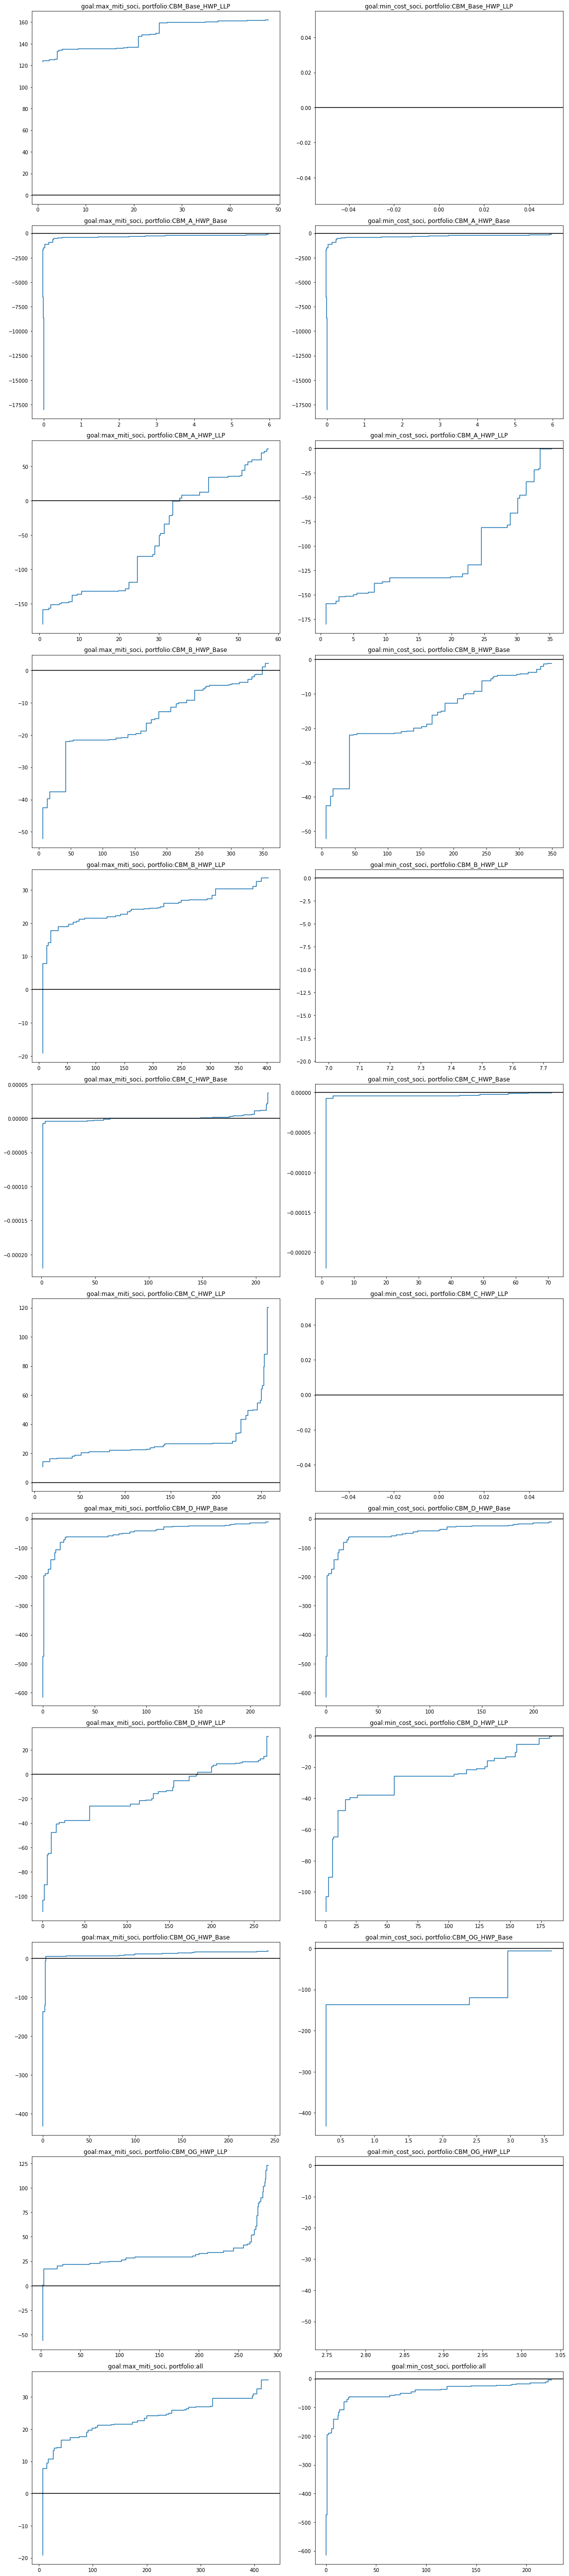

In [53]:
nrows, ncols, h, w, _sf = len(portfolios), len(goals), 3., 4., 2. 
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w*_sf, nrows*h*_sf))
for gid, goal in goals.items():
    for pid, portfolio in portfolios.items():
        df = r.loc[gid, pid].sort_values(by='unit_cost_soci')
        ax[pid][gid].step(x=-df['sum_tne'].cumsum(), y=df['unit_cost_soci'], where='pre')
        #ax[pid][gid].scatter(x=df['sum_dtne_soci'].cumsum(), y=df['unit_cost_soci'])
        #df.plot(x=df['sum_dtne_soci'].cumsum(), y='unit_cost_soci', ax=ax[pid][gid], kind='step')
        ax[pid][gid].set_title('goal:%s, portfolio:%s' % (goals[gid]['label'], portfolios[pid]['label']))
        ax[pid][gid].axhline(y=0, color='k')
        
plt.tight_layout()
plt.savefig('macc.pdf', format='pdf')